<a href="https://colab.research.google.com/github/DomizianoScarcelli/big-data-project/blob/dev/NN_recommender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Install dependencies

In [1]:
!pip install petastorm -qq
!pip install pyspark -qq
!pip install -U -q PyDrive -qq
!apt install openjdk-8-jdk-headless -qq

openjdk-8-jdk-headless is already the newest version (8u372-ga~us1-0ubuntu1~20.04).
0 upgraded, 0 newly installed, 0 to remove and 38 not upgraded.


In [2]:
#@title Imports
import os
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import plotly

import pyspark
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, ArrayType, FloatType, LongType
import pyspark.sql.functions as F
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession, DataFrame
from pyspark.ml.linalg import SparseVector, DenseVector, VectorUDT

from tqdm.notebook import tqdm
import time
import gc
import torch
from typing import Tuple, List


from google.colab import drive
from petastorm import make_batch_reader
from petastorm.pytorch import DataLoader

In [3]:
#@title Set up variables
JAVA_HOME = "/usr/lib/jvm/java-8-openjdk-amd64"
GDRIVE_DIR = "/content/drive"
GDRIVE_HOME_DIR = GDRIVE_DIR + "/MyDrive"
GDRIVE_DATA_DIR = GDRIVE_HOME_DIR + "/Big Data/datasets"
DATASET_FILE = os.path.join(GDRIVE_DATA_DIR, "pyspark_friendly_spotify_playlist_dataset")
AUDIO_FEATURES_FILE = os.path.join(GDRIVE_DATA_DIR, "pyspark_track_features")
LITTLE_SLICE_FILE = os.path.join(GDRIVE_DATA_DIR, "little_slice")
SMALL_SLICE_FLIE = os.path.join(GDRIVE_DATA_DIR, "small_slice")
LITTLE_SLICE_AUDIO_FEATURES = os.path.join(GDRIVE_DATA_DIR, "little_slice_audio_features")
MICRO_SLICE_AUDIO_FEATURES = os.path.join(GDRIVE_DATA_DIR, "micro_slice_audio_features")
SPLITTED_SLICE_AUDIO_FEATURES = os.path.join(GDRIVE_DATA_DIR, "splitted_pyspark_track_features")
SAVED_DFS_PATH = os.path.join(GDRIVE_DATA_DIR, "saved_dfs")
RANDOM_SEED = 42 # for reproducibility
SAVED_MODELS = os.path.join(GDRIVE_DATA_DIR, "saved_models")
os.environ["JAVA_HOME"] = JAVA_HOME
os.environ["PYSPARK_PYTHON"]="python"

In [4]:
drive.mount(GDRIVE_DIR, force_remount=True)

Mounted at /content/drive


In [5]:
#@title Create the session
conf = SparkConf().\
                set('spark.ui.port', "4050").\
                set('spark.executor.memory', '12G').\
                set('spark.driver.memory', '12G').\
                set('spark.driver.maxResultSize', '100G').\
                set("spark.executor.extraJavaOptions", "-XX:+UseG1GC").\
                setAppName("PySparkTutorial").\
                setMaster("local[*]")

# Create the context
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()

# Data acquisition

In [6]:
playlist_schema_mapped = StructType([
    StructField("name", StringType(), True),
    StructField("collaborative", StringType(), True),
    StructField("pid", IntegerType(), True),
    StructField("modified_at", IntegerType(), True),
    StructField("num_tracks", IntegerType(), True),
    StructField("num_albums", IntegerType(), True),
    StructField("num_followers", IntegerType(), True),
    StructField("tracks", VectorUDT(), True),
    StructField("num_edits", IntegerType(), True),
    StructField("duration_ms", IntegerType(), True),
    StructField("num_artists", IntegerType(), True),
])


In [7]:
import warnings
warnings.filterwarnings('ignore')

In [8]:
NUM_PLAYLISTS = 100_000
SONGS_EMBEDDINGS_PATH = os.path.join(SAVED_DFS_PATH, f"nn_songs_embeddings-train-{NUM_PLAYLISTS}.json")
SONGS_INFO_DF_PATH = os.path.join(SAVED_DFS_PATH, f"nn_songs_info_df-{NUM_PLAYLISTS}.json")
SONGS_VECTOR_LENGTH_PATH = os.path.join(SAVED_DFS_PATH, f"nn_songs_vector_length-{NUM_PLAYLISTS}.txt")

ARTIST_VECTOR_LENGTH_PATH = os.path.join(SAVED_DFS_PATH, f"nn_artist_vector_length-{NUM_PLAYLISTS}.txt")
ARTISTS_EMBEDDINGS_PATH = os.path.join(SAVED_DFS_PATH, f"nn_artists_embeddings-train-{NUM_PLAYLISTS}.json")

In [9]:
songs_embeddings = spark.read.schema(playlist_schema_mapped).json(SONGS_EMBEDDINGS_PATH)
artists_embeddings = spark.read.schema(playlist_schema_mapped).json(ARTISTS_EMBEDDINGS_PATH)
song_mapping = spark.read.json(SONGS_INFO_DF_PATH)

with open(ARTIST_VECTOR_LENGTH_PATH, "r") as f:
  content = f.read()
  ARTIST_VECTOR_LENGTH = int(content) + 1
with open(SONGS_VECTOR_LENGTH_PATH, "r") as f:
  content = f.read()
  SONGS_VECTOR_LENGTH = int(content) + 1

In [10]:
songs_embeddings.show(), artists_embeddings.show(), ARTIST_VECTOR_LENGTH, SONGS_VECTOR_LENGTH

+------------------+-------------+-----+-----------+----------+----------+-------------+--------------------+---------+-----------+-----------+
|              name|collaborative|  pid|modified_at|num_tracks|num_albums|num_followers|              tracks|num_edits|duration_ms|num_artists|
+------------------+-------------+-----+-----------+----------+----------+-------------+--------------------+---------+-----------+-----------+
|               Mix|        false|24770| 1376352000|        67|        43|            1|(133478,[85,3092,...|       32|   16179675|         34|
|         C H I L L|        false|84782| 1508889600|       105|        79|            2|(133478,[257,1952...|       74|   23647221|         59|
|    COACHELLA 2013|        false| 3188| 1366675200|       207|        87|            1|(133478,[143,147,...|       16|   49566298|         41|
|              Heat|        false| 3879| 1492992000|        27|        20|            2|(133478,[1172,373...|       11|    5580836|     

(None, None, 52470, 133478)

# Convert PySpark DataFrame into PyTorch DataLoader

In [11]:
def convert_sparse_to_indices(df: DataFrame) -> DataFrame:
  """
  Given a dataframe fo columns "pos":int and "tracks":SparseVector, it returns a new dataframe where
  the SparseVector are replaced with a list of the indices where the values are.
  (The value information is lost, but we don't care since they are binary values so they will be all ones)
  """

  @F.udf(returnType=ArrayType(IntegerType()))
  def transform_array(item: SparseVector):
    """
    Given a SparseVector (binary) it returns the tuple that represent it, of the type (size, indices)
    """
    indices_list = item.indices.tolist()
    padding_width = max_songs - len(indices_list)
    return indices_list + [-1] * padding_width
  
  max_songs = songs_embeddings.select(F.max("num_tracks")).first()[0]
  print(f"Max number of songs: {max_songs}")
  df = df.withColumn("embedding_indices", transform_array(F.col("tracks"))).drop("tracks")
  return df


In [12]:
def padded_tensors_to_sparse_matrix(padded_tensor: torch.Tensor, shape: tuple) -> torch.Tensor:
  batch_size, max_songs = padded_tensor.size(0), padded_tensor.size(1)
  rows = []
  for row_idx in range(batch_size):
    row = padded_tensor[row_idx]
    indices = row[row != -1]
    sparse_tensor = torch.sparse_coo_tensor(indices.unsqueeze(0), torch.ones(indices.shape), shape)
    rows.append(sparse_tensor)
  return torch.stack(rows)

def padded_tensors_to_dense_matrix(padded_tensor: torch.Tensor, shape: tuple) -> torch.Tensor:
  batch_size, max_songs = padded_tensor.size(0), padded_tensor.size(1)
  rows = []
  for row_idx in range(batch_size):
    row = padded_tensor[row_idx]
    indices = row[row != -1]
    sparse_tensor = torch.sparse_coo_tensor(indices.unsqueeze(0), torch.ones(indices.shape), shape)
    dense = sparse_tensor.to_dense()
    rows.append(dense)
  unpadded = torch.stack(rows)
  return unpadded

In the paper they have two matrices,l et $n$ be the number of unique songs, $m$ the number of playlists and $k$ the number of unique artists:

- $P \in \mathbb{R}^{m \times n}$ where $p_i = 1$ if song $i$ is in the playlist, $p_i=0$ otherwise
- $A \in \mathbb{R}^{m \times k}$ where $a_i=1$ if the artist is present in the playlist, $a_i = 0$ otherwise

In [13]:
from petastorm.spark import SparkDatasetConverter, make_spark_converter
from petastorm.unischema import dict_to_spark_row, Unischema, UnischemaField
from petastorm.codecs import ScalarCodec, CompressedImageCodec, NdarrayCodec
from torchvision import transforms
from petastorm import TransformSpec

CACHE = os.path.join(GDRIVE_DIR, "/big_data/cache_5")
spark.conf.set(SparkDatasetConverter.PARENT_CACHE_DIR_URL_CONF, f'file://{CACHE}')

pytorch_songs_df = convert_sparse_to_indices(songs_embeddings.select("tracks"))
songs_converter = make_spark_converter(pytorch_songs_df)

pytorch_artists_df = convert_sparse_to_indices(artists_embeddings.select("tracks"))
artist_converter = make_spark_converter(pytorch_artists_df)

Max number of songs: 250


Max number of songs: 250


# PyTorch Model

In [32]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pickle

class DAE_tied(nn.Module):
    def __init__(self, conf):
        super(DAE_tied, self).__init__()
        self.save_dir = conf["save"]
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.n_batch = conf["batch"]
        self.n_input = conf["n_input"]
        self.n_hidden = conf["hidden"]
        self.reg_lambda = conf["reg_lambda"]

        self.keep_prob = torch.tensor(conf["keep_prob"], dtype=torch.float32)
        self.input_keep_prob = torch.tensor(conf["input_keep_prob"], dtype=torch.float32)

        self.weights = {}
        self.biases = {}
        self.d_params = []

    def init_weight(self):
        self.weights['encoder_h'] = nn.Parameter(torch.FloatTensor(self.n_input, self.n_hidden).to(self.device))
        nn.init.xavier_uniform_(self.weights['encoder_h'])
        self.biases['encoder_b'] = nn.Parameter(torch.FloatTensor(self.n_hidden).to(self.device))
        nn.init.zeros_(self.biases['encoder_b'])
        self.biases['decoder_b'] = nn.Parameter(torch.FloatTensor(self.n_input).to(self.device))
        nn.init.zeros_(self.biases['decoder_b'])
        self.d_params = [self.weights['encoder_h'], self.weights['encoder_h'], self.biases['encoder_b'], self.biases['decoder_b']]

    # Building the encoder
    def encoder(self, x):
        # Encoder Hidden layer with sigmoid activation #1
        layer = torch.add(torch.matmul(x, self.weights['encoder_h']), self.biases['encoder_b'])
        layer = torch.sigmoid(layer)
        layer = torch.nn.functional.dropout(layer, p=1 - self.keep_prob)

        return layer

    # Building the decoder
    def decoder(self, x):
        # Decoder Hidden layer with sigmoid activation #1
        layer = torch.sigmoid(torch.add(torch.matmul(x, self.weights['encoder_h'].t()), self.biases['decoder_b']))
        return layer

    def l2_loss(self):
      encoder_h_l2 = (torch.sum(self.weights['encoder_h']) ** 2)/2
      decoder_b_l2 = (torch.sum(self.biases['decoder_b']) ** 2)/2
      encoder_b_l2 = (torch.sum(self.biases['encoder_b']) ** 2)/2

      l2 = encoder_h_l2 + decoder_b_l2 + encoder_b_l2
      return l2

    def forward(self, x, y):

        # TODO: Take sparse matrix representation instead of dense
        # self.x = x_positxions
        # self.x_ones = x_ones
        # self.y_positions = y_positions
        # self.y_ones = y_ones

        self.x = x.t()
        self.y = y.t()

        # x_sparse = torch.sparse.FloatTensor(self.x_positions.t(), self.x_ones, torch.Size([self.n_batch, self.n_input]))
        # self.x = x_sparse.to_dense()
        # y_sparse = torch.sparse.FloatTensor(self.y_positions.t(), self.y_ones, torch.Size([self.n_batch, self.n_input]))
        # self.y = y_sparse.to_dense()

        x_dropout = torch.nn.functional.dropout(self.x, p= 1 - self.input_keep_prob)
        reduce_sum = torch.sum(x_dropout, dim=1, keepdim=True)
        self.x_dropout = torch.div(x_dropout, reduce_sum + 1e-10)

        encoder_op = self.encoder(self.x_dropout)
        self.y_pred = self.decoder(encoder_op)

        l2 = self.l2_loss()

        L = -torch.sum(self.y * torch.log(self.y_pred + 1e-10) +
                       0.55 * (1 - self.y) * torch.log(1 - self.y_pred + 1e-10), dim=1)
        self.cost = torch.mean(L) + self.reg_lambda * l2

    def save_model(self):
        params = [param.detach().numpy() for param in self.d_params]
        with open(self.save_dir, 'wb') as f:
            pickle.dump(params, f)

            
class DAE(DAE_tied):
    def __init__(self, conf):
        super(DAE, self).__init__(conf)
        self.initval_dir = conf["initval"]

    def init_weight(self):
        if self.initval_dir == 'NULL':
            self.weights['encoder_h'] = nn.Parameter(torch.FloatTensor(self.n_input, self.n_hidden).to(self.device))
            nn.init.xavier_uniform_(self.weights['encoder_h'])
            self.weights['decoder_h'] = nn.Parameter(torch.FloatTensor(self.n_input, self.n_hidden).to(self.device))
            nn.init.xavier_uniform_(self.weights['decoder_h'])
            self.biases['encoder_b'] = nn.Parameter(torch.FloatTensor(self.n_hidden).to(self.device))
            nn.init.zeros_(self.biases['encoder_b'])
            self.biases['decoder_b'] = nn.Parameter(torch.FloatTensor(self.n_input).to(self.device))
            nn.init.zeros_(self.biases['decoder_b'])
        else:
            with open(self.initval_dir, 'rb') as f:
                emb = pickle.load(f)
            self.weights['encoder_h'] = nn.Parameter(torch.FloatTensor(emb[0]).to(self.device))
            self.weights['decoder_h'] = nn.Parameter(torch.FloatTensor(emb[1]).to(self.device))
            self.biases['encoder_b'] = nn.Parameter(torch.FloatTensor(emb[2]).to(self.device))
            self.biases['decoder_b'] = nn.Parameter(torch.FloatTensor(emb[3]).to(self.device))

        self.d_params = [self.weights['encoder_h'], self.weights['decoder_h'],
                         self.biases['encoder_b'], self.biases['decoder_b']]

    def decoder(self, x):
        # Decoder Hidden layer with sigmoid activation #1
        layer = torch.sigmoid(torch.add(torch.matmul(x, self.weights['decoder_h'].t()), self.biases['decoder_b']))
        return layer

    def l2_loss(self):
      encoder_h_l2 = (torch.sum(self.weights['encoder_h']) ** 2)/2
      decoder_b_l2 = (torch.sum(self.biases['decoder_b']) ** 2)/2
      encoder_b_l2 = (torch.sum(self.biases['encoder_b']) ** 2)/2
      decoder_h_l2 = (torch.sum(self.weights['decoder_h']) ** 2)/2

      l2 = encoder_h_l2 + decoder_b_l2 + encoder_b_l2 + decoder_h_l2
      return l2

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [38]:
#Hyperparameters used in the paper
conf = {
    'batch': 250,
    'n_input': SONGS_VECTOR_LENGTH + ARTIST_VECTOR_LENGTH - 2, #-2 to compense the first row of zeros since the pos in the df start at 1
    'hidden': 256,
    'lr': 0.0001,
    'reg_lambda': 0.0,
    'initval': "NULL",
    "keep_prob": 0.8, 
    "input_keep_prob": 0.8, # This isn't used for now because of the .uniform()
    'save': os.path.join(SAVED_MODELS, "dae_model.pickle")
}
pretrain_model = DAE_tied(conf)
pretrain_model.init_weight()
pretrain_model.train()
# optimizer = optim.SGD(dae_model.d_params, lr=conf['lr'], momentum=0.9)

DAE_tied()

In [39]:
pretrain_optimizer = optim.Adam(pretrain_model.d_params, lr=conf['lr'])

In [40]:
pretrain_model.weights['encoder_h'].device

device(type='cuda', index=0)

## Train the model

In [41]:
min_loss = 600
best_params = []
losses = []
BEST_PARAMS_PATH = os.path.join(SAVED_MODELS, "best_params.pickle")

Pretrain with `DAE_tied`

In [42]:
from tqdm.notebook import tqdm
import random
NUM_EPOCHS = 10
with songs_converter.make_torch_dataloader(batch_size=conf["batch"], num_epochs = NUM_EPOCHS) as songs_dataloader:
  with artist_converter.make_torch_dataloader(batch_size=conf["batch"], num_epochs = NUM_EPOCHS) as artists_dataloader:
    ARTIST_SHAPE = (ARTIST_VECTOR_LENGTH, )
    SONG_SHAPE = (SONGS_VECTOR_LENGTH, )
    # for epoch in tqdm(range(num_epochs), desc="Training..."):
    zipped_dataloaders = zip(songs_dataloader, artists_dataloader)
    for batch_idx, (song, artist) in tqdm(enumerate(zipped_dataloaders), desc=f"Training model", total= (NUM_PLAYLISTS / conf["batch"]) * NUM_EPOCHS):
      # Pick random input_keep_prob between 0.5 and 0.8
      pretrain_model.input_keep_prob = random.uniform(0.5, 0.8) #TODO: make this dynamic inside the conf

      padded_song_tensor = song["embedding_indices"]
      padded_artist_tensor = artist["embedding_indices"]
      
      song_dense = padded_tensors_to_dense_matrix(padded_song_tensor, SONG_SHAPE)[:, 1:]
      artist_dense = padded_tensors_to_dense_matrix(padded_artist_tensor, ARTIST_SHAPE)[:, 1:]

      song_dense = song_dense.to(device)
      artist_dense = artist_dense.to(device)

      rand_int = np.random.randint(2)
      if rand_int == 0:
        #Zero-out the artists
        pretrain_optimizer.zero_grad()
        x = torch.concat((song_dense, torch.zeros_like(artist_dense)), dim=1).t()
        y = torch.concat((song_dense, artist_dense), dim=1).t()
        pretrain_model(x, y)
        loss = pretrain_model.cost
        pretrain_model.cost.backward()
        pretrain_optimizer.step()
      if rand_int == 1:
        #Zero-out the tracks
        pretrain_optimizer.zero_grad()
        x = torch.concat((torch.zeros_like(song_dense), artist_dense), dim=1).t()
        y = torch.concat((song_dense, artist_dense), dim=1).t()
        pretrain_model(x, y)
        loss = pretrain_model.cost
        pretrain_model.cost.backward()
        pretrain_optimizer.step()

      losses.append(loss)

     
      if loss < min_loss:
        min_loss = loss
        del best_params
        best_params = [param.cpu().detach().numpy() for param in pretrain_model.d_params]
        with open(BEST_PARAMS_PATH, "wb") as f:
          pickle.dump(best_params, f)
        print(f"Best loss achieved: {min_loss}, parameters saved!")

      if batch_idx % 10 == 0:
        print(f"Loss: {loss}")


Training model:   0%|          | 0/4000.0 [00:00<?, ?it/s]

Loss: 70926.5625
Loss: 58117.76171875
Loss: 47750.6640625
Loss: 39354.03515625
Loss: 32790.59765625
Loss: 27722.44140625
Loss: 23660.08203125
Loss: 20278.75
Loss: 17666.892578125
Loss: 15633.5498046875
Loss: 13794.3291015625
Loss: 12377.146484375
Loss: 11154.37109375
Loss: 10227.138671875
Loss: 9302.0390625
Loss: 8394.75
Loss: 7803.23046875
Loss: 7168.8330078125
Loss: 6660.982421875
Loss: 6158.46142578125
Loss: 5785.83154296875
Loss: 5475.69482421875
Loss: 5053.5244140625
Loss: 4799.4169921875
Loss: 4516.29345703125
Loss: 4282.68603515625
Loss: 4086.874755859375
Loss: 3881.482666015625
Loss: 3651.048583984375
Loss: 3522.002197265625
Loss: 3374.5263671875
Loss: 3150.6171875
Loss: 3064.9560546875
Loss: 2925.216552734375
Loss: 2837.006591796875
Loss: 2731.4912109375
Loss: 2654.067626953125
Loss: 2582.378662109375
Loss: 2421.62890625
Loss: 2332.24560546875
Loss: 2311.985595703125
Loss: 2227.777099609375
Loss: 2129.173095703125
Loss: 2092.51904296875
Loss: 2085.897216796875
Loss: 1975.44763

KeyboardInterrupt: ignored

Train with `DAE` loading the pretrained `DAE_tied` model

In [45]:
conf = {
    'batch': 250,
    'n_input': SONGS_VECTOR_LENGTH + ARTIST_VECTOR_LENGTH - 2, #-2 to compense the first row of zeros since the pos in the df start at 1
    'hidden': 256,
    'lr': 0.000005, #remove one zero
    'reg_lambda': 0.0,
    'initval': BEST_PARAMS_PATH,
    "keep_prob": 0.8, 
    "input_keep_prob": 0.8, # This isn't used for now because of the .uniform()
    'save': os.path.join(SAVED_MODELS, "dae_model.pickle")
}
dae_model = DAE(conf)
dae_model.init_weight()
optimizer = optim.Adam(dae_model.d_params, lr=conf['lr'])

min_loss = 600
losses = []
best_params = []
FINE_TUNED_BEST_PARAMS_PATH = os.path.join(SAVED_MODELS, "final_best_params.pickle")

In [46]:
from tqdm.notebook import tqdm
import random
NUM_EPOCHS = 10
with songs_converter.make_torch_dataloader(batch_size=conf["batch"], num_epochs = NUM_EPOCHS) as songs_dataloader:
  with artist_converter.make_torch_dataloader(batch_size=conf["batch"], num_epochs = NUM_EPOCHS) as artists_dataloader:
    ARTIST_SHAPE = (ARTIST_VECTOR_LENGTH, )
    SONG_SHAPE = (SONGS_VECTOR_LENGTH, )
    # for epoch in tqdm(range(num_epochs), desc="Training..."):
    zipped_dataloaders = zip(songs_dataloader, artists_dataloader)
    for batch_idx, (song, artist) in tqdm(enumerate(zipped_dataloaders), desc=f"Training model", total= (NUM_PLAYLISTS / conf["batch"]) * NUM_EPOCHS):
      # Pick random input_keep_prob between 0.5 and 0.8
      dae_model.input_keep_prob = random.uniform(0.5, 0.8) #TODO: make this dynamic inside the conf

      padded_song_tensor = song["embedding_indices"]
      padded_artist_tensor = artist["embedding_indices"]
      
      song_dense = padded_tensors_to_dense_matrix(padded_song_tensor, SONG_SHAPE)[:, 1:]
      artist_dense = padded_tensors_to_dense_matrix(padded_artist_tensor, ARTIST_SHAPE)[:, 1:]

      song_dense = song_dense.to(device)
      artist_dense = artist_dense.to(device)

      rand_int = np.random.randint(2)
      if rand_int == 0:
        #Zero-out the artists
        optimizer.zero_grad()
        x = torch.concat((song_dense, torch.zeros_like(artist_dense)), dim=1).t()
        y = torch.concat((song_dense, artist_dense), dim=1).t()
        dae_model(x, y)
        loss = dae_model.cost
        dae_model.cost.backward()
        optimizer.step()
      if rand_int == 1:
        #Zero-out the tracks
        optimizer.zero_grad()
        x = torch.concat((torch.zeros_like(song_dense), artist_dense), dim=1).t()
        y = torch.concat((song_dense, artist_dense), dim=1).t()
        dae_model(x, y)
        loss = dae_model.cost
        dae_model.cost.backward()
        optimizer.step()

      losses.append(loss)

     
      if loss < min_loss:
        min_loss = loss
        del best_params
        best_params = [param.cpu().detach().numpy() for param in pretrain_model.d_params]
        with open(BEST_PARAMS_PATH, "wb") as f:
          pickle.dump(best_params, f)
        print(f"Best loss achieved: {min_loss}, parameters saved!")

      if batch_idx % 10 == 0:
        print(f"Loss: {loss}")


Training model:   0%|          | 0/4000.0 [00:00<?, ?it/s]

Loss: 640.221923828125
Best loss achieved: 586.825927734375, parameters saved!
Loss: 638.6425170898438
Loss: 685.1658935546875
Best loss achieved: 570.0928955078125, parameters saved!
Loss: 670.8534545898438
Loss: 616.9705200195312


KeyboardInterrupt: ignored

Let's see how the loss decreases

In [ ]:
SAVE_MODEL_PATH = os.path.join(SAVED_DFS_PATH, f"model_new.pickle")
params = [param.cpu().detach().numpy() for param in dae_model.d_params]
with open(SAVE_MODEL_PATH, 'wb') as f:
  pickle.dump(params, f)

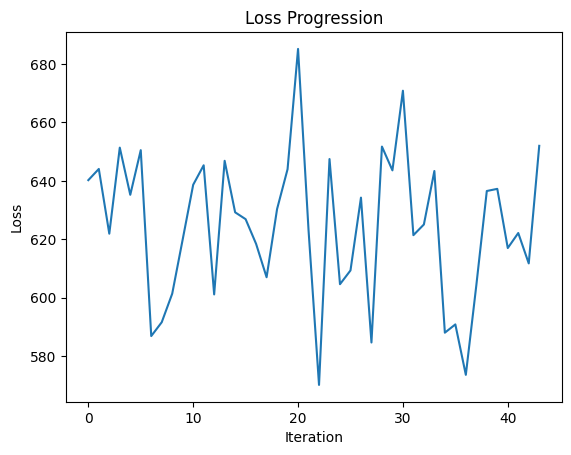

In [47]:
import matplotlib.pyplot as plt
x = np.arange(len(losses))
plt.plot(x, [loss.item() for loss in losses])
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss Progression')
plt.show()

# Inference

In [48]:
from pyspark.ml.linalg import VectorUDT
song_schema = StructType([
    StructField("pos", IntegerType(), True),
    StructField("artist_name", StringType(), True),
    StructField("track_uri", StringType(), True),
    StructField("artist_uri", StringType(), True),
    StructField("track_name", StringType(), True),
    StructField("album_uri", StringType(), True),
    StructField("duration_ms", LongType(), True),
    StructField("album_name", StringType(), True)
])

playlist_schema = StructType([
    StructField("name", StringType(), True),
    StructField("collaborative", StringType(), True),
    StructField("pid", IntegerType(), True),
    StructField("modified_at", IntegerType(), True),
    StructField("num_tracks", IntegerType(), True),
    StructField("num_albums", IntegerType(), True),
    StructField("num_followers", IntegerType(), True),
    StructField("tracks", ArrayType(song_schema), True),
    StructField("num_edits", IntegerType(), True),
    StructField("duration_ms", IntegerType(), True),
    StructField("num_artists", IntegerType(), True),
])

In [49]:
SONGS_EMBEDDINGS_PATH_TEST_TRAIN = os.path.join(SAVED_DFS_PATH, f"nn_songs_embeddings-test-train-{NUM_PLAYLISTS}.json")
SONGS_EMBEDDINGS_PATH_TEST_TEST = os.path.join(SAVED_DFS_PATH, f"nn_songs_embeddings-test-test-{NUM_PLAYLISTS}.json")

ARTISTS_EMBEDDINGS_PATH_TEST_TRAIN = os.path.join(SAVED_DFS_PATH, f"nn_artists_embeddings-test-train-{NUM_PLAYLISTS}.json")
ARTISTS_EMBEDDINGS_PATH_TEST_TEST = os.path.join(SAVED_DFS_PATH, f"nn_artists_embeddings-test-test-{NUM_PLAYLISTS}.json")

songs_embeddings_test_train = spark.read.schema(playlist_schema_mapped).json(SONGS_EMBEDDINGS_PATH_TEST_TRAIN)
songs_embeddings_test_test = spark.read.schema(playlist_schema_mapped).json(SONGS_EMBEDDINGS_PATH_TEST_TEST)

artists_embeddings_test_train = spark.read.schema(playlist_schema_mapped).json(ARTISTS_EMBEDDINGS_PATH_TEST_TRAIN)
artists_embeddings_test_test = spark.read.schema(playlist_schema_mapped).json(ARTISTS_EMBEDDINGS_PATH_TEST_TEST)

TEST_TRAIN_DF_PATH = os.path.join(SAVED_DFS_PATH, f"nn_test_df-train-{NUM_PLAYLISTS}.json")
TEST_TEST_DF_PATH = os.path.join(SAVED_DFS_PATH, f"nn_test_df-test-{NUM_PLAYLISTS}.json")

test_train_df = spark.read.schema(playlist_schema).json(TEST_TRAIN_DF_PATH)
test_test_df = spark.read.schema(playlist_schema).json(TEST_TEST_DF_PATH)

In [50]:
def construct_prediction_df(prediction: torch.Tensor, mapping: DataFrame, top_n: int = 50) -> DataFrame:
  pred_np = prediction.detach().numpy()
  indexes = np.arange(pred_np.shape[0]) + 1 # To compensate the index start at 1
  schema = StructType([
      StructField("pos", IntegerType()),
      StructField("confidence", FloatType())
  ])
  prediction_df = spark.createDataFrame([(pos, conf) for pos, conf in zip(indexes.tolist(), pred_np.tolist())],schema)
  prediction_info = prediction_df.join(mapping, "pos")
  return prediction_info

# prediction_df = construct_prediction_df(prediction, songs_df_test)
# prediction_df.show()

In [51]:
def remove_existing_tracks(playlist_tracks: DataFrame, recommendations_df: DataFrame) -> DataFrame:
  playlist_tracks = playlist_tracks.select("track_uri").cache()
  playlist_tracks_compatible = playlist_tracks.join(F.broadcast(recommendations_df), on="track_uri")
  playlist_tracks.unpersist()
  return recommendations_df.exceptAll(F.broadcast(playlist_tracks_compatible))

# Evaluation

In [52]:
def precision_at_k(recommendations, ground_truth, num_of_recommendations) -> float:
    """
    Calculates precision at k for the recommendations.
    """
    recommended_relevant_tracks = recommendations.join(ground_truth, "track_uri").cache()
    reccomended_relevant_tracks_count = recommended_relevant_tracks.count() #this can be top_n_results.join in order to be more performant
    recommended_relevant_tracks.unpersist()
    precision = reccomended_relevant_tracks_count / float(num_of_recommendations)

    return precision


import math
def normalized_discounted_cumulative_gain(recommendations: DataFrame, ground_truth: DataFrame, num_of_recommendations: int) -> float:
  recommendations_list = recommendations.collect()
  cumulative_gain = 0

  intersection = recommendations.join(ground_truth, "track_uri").count()
  if intersection == 0: return 0

  ideal_cumulative_gain = 1 + np.array([(1 / math.log(i, 2)) for i in range(2, 2+intersection)]).sum() #TODO: replace this with sum([])
  for index, row in enumerate(recommendations_list):
    i = index + 1
    is_rel = ground_truth.filter(F.col("track_uri").isin(row.track_uri)).count() > 0
    rel = 1 if is_rel else 0
    if i == 1:
      cumulative_gain += rel
    else:
      cumulative_gain += (rel / math.log(i, 2))
  return cumulative_gain / ideal_cumulative_gain

Creating the dataloaders for the test set

In [53]:
CACHE = os.path.join(GDRIVE_DIR, "/big_data/cache_5")
spark.conf.set(SparkDatasetConverter.PARENT_CACHE_DIR_URL_CONF, f'file://{CACHE}')

pytorch_songs_df_test = convert_sparse_to_indices(songs_embeddings_test_train.select("tracks"))
songs_converter_test = make_spark_converter(pytorch_songs_df_test)

pytorch_artists_df_test = convert_sparse_to_indices(artists_embeddings_test_train.select("tracks"))
artist_converter_test = make_spark_converter(pytorch_artists_df_test)

Max number of songs: 250


Max number of songs: 250


In [58]:
#Hyperparameters used in the paper
conf = {
    'batch': 150,
    'n_input': SONGS_VECTOR_LENGTH + ARTIST_VECTOR_LENGTH - 2, #-2 to compense the first row of zeros since the pos in the df starts at 1,
    'hidden': 256,
    'lr': 0.001, #original 0.001
    'reg_lambda': 0.0,
    'initval': BEST_PARAMS_PATH,
    "keep_prob": 1,
    "input_keep_prob": 1,
    'save': os.path.join(SAVED_MODELS, "dae_model.pickle")
}
dae_model_test = DAE(conf)
dae_model_test.init_weight()
dae_model_test.eval()

DAE()

In [59]:
ARTIST_SHAPE = (ARTIST_VECTOR_LENGTH, )
SONG_SHAPE = (SONGS_VECTOR_LENGTH, )
with songs_converter_test.make_torch_dataloader(batch_size=conf["batch"], num_epochs =1) as songs_dataloader:
  with artist_converter_test.make_torch_dataloader(batch_size=conf["batch"], num_epochs=1) as artists_dataloader:
    zipped_dataloaders = zip(songs_dataloader, artists_dataloader)
    for batch_idx, (song, artist) in tqdm(enumerate(zipped_dataloaders), desc=f"Evaluation...", total= (NUM_PLAYLISTS / conf["batch"])):
      padded_song_tensor = song["embedding_indices"]
      padded_artist_tensor = artist["embedding_indices"]
      
      song_dense = padded_tensors_to_dense_matrix(padded_song_tensor, SONG_SHAPE)[:, 1:]
      artist_dense = padded_tensors_to_dense_matrix(padded_artist_tensor, ARTIST_SHAPE)[:, 1:]

      song_dense = song_dense.to(device)
      artist_dense = artist_dense.to(device)

      x = torch.concat((song_dense, artist_dense), dim=1).t()
      y = torch.concat((song_dense, artist_dense), dim=1).t()
      
      dae_model_test(x,y)
      
      result = dae_model_test.y_pred
      break

Evaluation...:   0%|          | 0/666.6666666666666 [00:00<?, ?it/s]

In [60]:
result

tensor([[0.0204, 0.0013, 0.0060,  ..., 0.0006, 0.0006, 0.0006],
        [0.0209, 0.0014, 0.0062,  ..., 0.0006, 0.0006, 0.0006],
        [0.0204, 0.0013, 0.0060,  ..., 0.0006, 0.0006, 0.0006],
        ...,
        [0.0205, 0.0013, 0.0060,  ..., 0.0006, 0.0006, 0.0006],
        [0.0203, 0.0013, 0.0059,  ..., 0.0006, 0.0006, 0.0006],
        [0.0202, 0.0013, 0.0059,  ..., 0.0006, 0.0006, 0.0006]],
       device='cuda:0', grad_fn=<SigmoidBackward0>)

In [ ]:
# torch.concat((song_dense[:, 1:], artist_dense[:, 1:]), dim=1).t().shape
# (song_dense[:, 0] == 0.).all(), (artist_dense[:, 0] == 0.).all()

In [ ]:
# result = result.to("cpu")
# prediction_df = construct_prediction_df(result[10][:SONGS_VECTOR_LENGTH_TEST], songs_df_test, 20)

In [ ]:
# prediction_df.orderBy("pos").show(truncate=False)
# songs_df_test.show()

In [30]:
# def evaluate_batch(batch_result: torch.Tensor, batch_n: int) -> Tuple[float, float]:
#   """
#   Returns the precision and NDCG for a given batch.
#   """
  
#   return 0,0

# def perform_evaluation(songs_dataloader, artists_dataloader, test_set):
#   """
#   Returns the precision and NDCG, averaged from all the samples in the test set
#   """
#   with songs_converter_test.make_torch_dataloader(num_epochs =1) as songs_dataloader:
#     with artist_converter_test.make_torch_dataloader(num_epochs=1) as artists_dataloader:
#       zipped_dataloaders = zip(songs_dataloader, artists_dataloader)
#       for batch_idx, (song, artist) in tqdm(enumerate(zipped_dataloaders), desc=f"Evaluation...", total= (NUM_PLAYLISTS / 32) * NUM_EPOCHS):
#         padded_song_tensor = song["embedding_indices"]
#         padded_artist_tensor = artist["embedding_indices"]
        
#         song_dense = padded_tensors_to_dense_matrix(padded_song_tensor, SONG_SHAPE)
#         artist_dense = padded_tensors_to_dense_matrix(padded_artist_tensor, ARTIST_SHAPE)

#         x = torch.concat((song_dense, artist_dense), dim=1).t()
#         y = torch.concat((song_dense, artist_dense), dim=1).t()
#         dae_model(x,y)
#         batch_result = dae_model.y_pred
#         break


In [61]:
#Testing the first playlist
#TODO: maybe this is not the right way of making a prediction
results = []
for i in tqdm(range(32)):
  ground_truth = test_test_df.filter(F.col("pid") == 1000 + i).select(F.explode("tracks")).select("col.*").cache()
  playlist_train_songs = test_train_df.filter(F.col("pid") == 1000 + i).select(F.explode("tracks")).select("col.*").cache()
  n_recommendations = ground_truth.count()
  result = result.cpu()

  prediction_df = construct_prediction_df(result[i][:SONGS_VECTOR_LENGTH], song_mapping, n_recommendations).cache()
  clean_prediction_df = remove_existing_tracks(playlist_train_songs, prediction_df)

  clean_prediction_df = prediction_df.orderBy(F.col("confidence").desc()).limit(n_recommendations).cache()

  prec = precision_at_k(clean_prediction_df, ground_truth, n_recommendations)
  gain = normalized_discounted_cumulative_gain(clean_prediction_df, ground_truth, n_recommendations)
  print(i, prec, gain)
  results.append((prec, gain))
  
  ground_truth.unpersist()
  playlist_train_songs.unpersist()
  prediction_df.unpersist()
  clean_prediction_df.unpersist()


  0%|          | 0/32 [00:00<?, ?it/s]

0 0.0 0


ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/usr/local/lib/python3.10/dist-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/usr/lib/python3.10/socket.py", line 705, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt


KeyboardInterrupt: ignored

In [62]:
playlist_train_songs.show(truncate=False)
ground_truth.show(truncate=False)
prediction_df.show(truncate=False)
clean_prediction_df.show(truncate=False)
prec, gain

+---+------------------------+------------------------------------+-------------------------------------+--------------------------------------------------------------+------------------------------------+-----------+-----------------------------------------+
|pos|artist_name             |track_uri                           |artist_uri                           |track_name                                                    |album_uri                           |duration_ms|album_name                               |
+---+------------------------+------------------------------------+-------------------------------------+--------------------------------------------------------------+------------------------------------+-----------+-----------------------------------------+
|15 |The Octopus Project     |spotify:track:3RjTS80WoMLmy7QDQlVjo0|spotify:artist:7EFRvnUHNLWOYVPg8AuI7o|It Hurts to Shoot Lazers from Your Fingers, But It's Necessary|spotify:album:459fUY8KMLna0jiAXAYBNh|6000       |The

(0.0, 0)

In [ ]:
def average_results(results):
  prec_avg = sum(prec for prec, _ in results) / len(results)
  gain_avg = sum(gain for _, gain in results) / len(results)
  return prec_avg, gain_avg

average_results(results)